In this competition, Kaggle is challenging you to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

Longtime Kagglers will recognize that this competition objective is similar to the ECML/PKDD trip time challenge we hosted in 2015. But, this challenge comes with a twist. Instead of awarding prizes to the top finishers on the leaderboard, this playground competition was created to reward collaboration and collective learning.

We are encouraging you (with cash prizes!) to publish additional training data that other participants can use for their predictions. We also have designated bi-weekly and final prizes to reward authors of kernels that are particularly insightful or valuable to the community.

# Import


In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb

import os
from pathlib import Path

# importer la lib pour cross valider le model
from sklearn.model_selection import cross_val_score

# importer la lib pour la regression de Random Forest
from sklearn.ensemble import RandomForestRegressor

# importer la lib pour la regression de Random Forest
from sklearn.linear_model import SGDRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import ShuffleSplit


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt


%matplotlib inline

# 1. Data loading

In [2]:
#train = pd.read_csv('training/train.csv')
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample = pd.read_csv('../input/sample_submission.csv')


In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


# 2. Data exploration

In [6]:
train.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
train.trip_duration.min()


1

In [8]:
train.trip_duration.max()

3526282

Dans 1 minute, il y a 60 secondes  
Dans 1 heure, il y a 60 minutes. donc 60 * 60= 3600secondes  
Dans 1 journée, il y a 24 heures. donc 24*3600= 86400 secondes.  
=> 3526282/86400 = 40,81344907 jours


On peut voir qu'il y a un temps de trajet minimum de 1 seconde et un maximum de 40 jours.
Il faudra les enlever car cela va fausser les résultats.  
Dans mon cas, je juge qu'un temps de trajet dans un taxi doit être comprise entre 5 minutes et quelques heures.

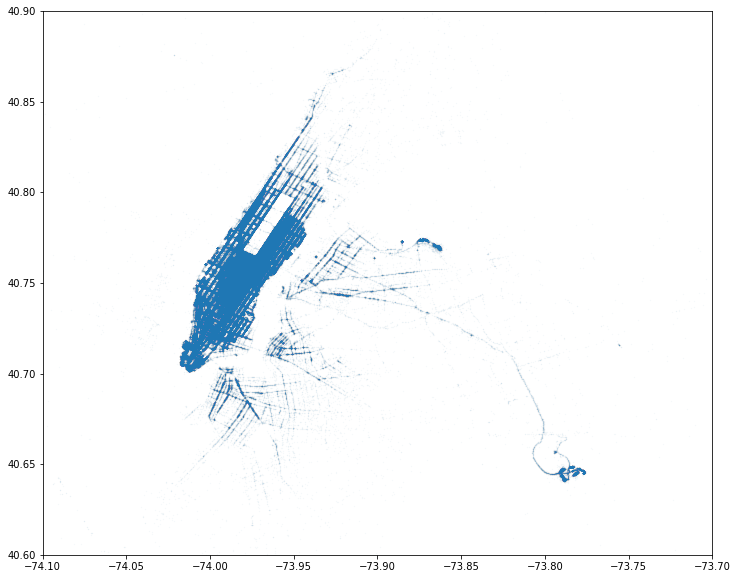

In [9]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.0002, alpha=1)

# 3. Data preprocessing :

#### 3.1 Gestion des Outliers

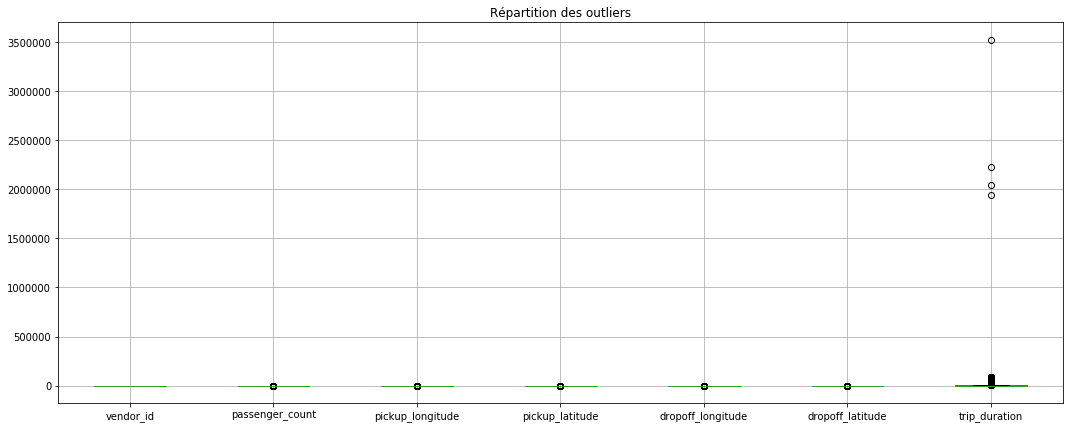

In [10]:
plt.subplots(figsize=(18,7))
plt.title("Répartition des outliers")
train.boxplot()

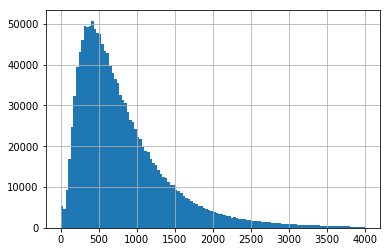

In [11]:
train.loc[train.trip_duration<4000,"trip_duration"].hist(bins=120)

1. 1. On pourra choisir un trip_duration max (4000) et trip_duration_min (0 car les trip_durations peuvent être nulls ou annulées)

In [12]:
train['passenger_count'].value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [13]:
train = train[train['passenger_count']>0]
train = train[train['passenger_count']<9]

In [14]:
train = train[(train['trip_duration'] > 60) & (train['trip_duration'] < 3600*6)]
train[train['trip_duration']<=120].shape
train[train['trip_duration']>=3600*6].shape
train['trip_duration'] = np.log(train['trip_duration'].values)

train['hour'] = train['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))


test['hour'] = test['pickup_datetime'].apply(lambda x: int(x.split()[1][0:2]))

#outliers coordonnés
train = train.loc[train['pickup_longitude']> -80]
train = train.loc[train['pickup_latitude']< 44]
train = train.loc[train['dropoff_longitude']> -90]
train = train.loc[train['dropoff_latitude']> 34]

distances

In [15]:
import math

def haversine(lat1, lon1, lat2, lon2):
   R = 6372800  # Earth radius in meters
   phi1, phi2 = math.radians(lat1), math.radians(lat2)
   dphi       = math.radians(lat2 - lat1)
   dlambda    = math.radians(lon2 - lon1)

   a = math.sin(dphi/2)**2 + \
       math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2

   return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

train['dist_long'] = train['pickup_longitude'] - train['dropoff_longitude']
test['dist_long'] = test['pickup_longitude'] - test['dropoff_longitude']

train['dist_lat'] = train['pickup_latitude'] - train['dropoff_latitude']
test['dist_lat'] = test['pickup_latitude'] - test['dropoff_latitude']

train['dist'] = np.sqrt(np.square(train['dist_long']) + np.square(train['dist_lat']))
test['dist'] = np.sqrt(np.square(test['dist_long']) + np.square(test['dist_lat']))

In [16]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])

train['hour'] = train.pickup_datetime.dt.hour
train['day'] = train.pickup_datetime.dt.dayofweek
train['month'] = train.pickup_datetime.dt.month
test['hour'] = test.pickup_datetime.dt.hour
test['day'] = test.pickup_datetime.dt.dayofweek
test['month'] = test.pickup_datetime.dt.month

Suppression vitesse incohérente & distance


#### 3.2 Missing values handling

In [17]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
hour                  0
dist_long             0
dist_lat              0
dist                  0
day                   0
month                 0
dtype: int64

#### 3.4 Scaling des données

# 4. Features engineering : selection, extraction, creation

In [18]:
col_diff = list(set(train.columns).difference(set(test.columns)))

In [19]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,hour,dist_long,dist_lat,dist,day,month
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,6.120297,17,-0.017525,0.002335,0.017680,0,3
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,6.496775,0,0.019066,0.007412,0.020456,6,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661056,11,0.026306,0.053852,0.059934,1,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,6.061457,19,0.002228,0.013252,0.013438,2,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,6.075346,13,-0.000130,0.010689,0.010690,5,3


In [20]:
y_train = train["trip_duration"] # <-- target
X_train = train[["vendor_id","passenger_count","pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","month","hour","day","dist"]] # <-- features

X_datatest = test[["vendor_id","passenger_count","pickup_longitude", "pickup_latitude", "dropoff_longitude","dropoff_latitude","month","hour","day","dist"]]

In [21]:
train.drop(['dist','hour']+col_diff, axis=1, inplace=True)

# 5. Sélection de modèles et/ou datasets (si il y en a plusieurs)****

In [22]:
# declarer le model et l'entrainer

#sgd = SGDRegressor()
#sgd.fit(X_train, y_train)

# 6. Entrainement du ou des modèle(s) & Predictions

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [24]:
rfr = RandomForestRegressor(n_estimators=100,min_samples_leaf=10, min_samples_split=15, max_depth=80,verbose=0,max_features="auto",bootstrap=True,n_jobs=-1)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=15,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [25]:
# Trop long
# calculer les scores de cross validation du model selon une decoupe du dataset de train
cv_scores = cross_val_score(rfr, X_train, y_train, cv=5, scoring= 'neg_mean_squared_log_error')

In [26]:
cv_scores

array([-0.00213956, -0.002132  , -0.00212856, -0.0021095 , -0.00215209])

In [27]:
for i in range(len(cv_scores)):
    cv_scores[i] = np.sqrt(abs(cv_scores[i]))
cv_scores



## xgb parameters
params = {
    'booster':            'gbtree',
    'objective':          'reg:linear',
    'learning_rate':      0.1,
    'max_depth':          14,
    'subsample':          0.8,
    'colsample_bytree':   0.7,
    'colsample_bylevel':  0.7,
    'silent':             1
}

In [28]:
nrounds = 1000
dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
gbm = xgb.train(params,
                dtrain,
                num_boost_round = nrounds)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [29]:
#train_pred = rfr.predict(X_datatest)
#train_pred[:5]

train_pred = np.exp(gbm.predict(xgb.DMatrix(X_datatest))) - 1
#train_pred[:5]

In [30]:
train_pred

array([6.7131915, 6.264576 , 6.0117164, ..., 7.402931 , 7.4737434,
       7.003709 ], dtype=float32)

In [31]:
my_submission = pd.DataFrame({"id": test.id, "trip_duration": np.exp(train_pred)})
print(my_submission)

               id  trip_duration
0       id3004672     823.193665
1       id3505355     525.618652
2       id1217141     408.183319
3       id2150126     958.185364
4       id1598245     486.796265
5       id0668992     880.106262
6       id1765014    1247.610474
7       id0898117     706.265564
8       id3905224    2418.288574
9       id1543102     567.006165
10      id3024712    1227.098511
11      id3665810     479.609039
12      id1836461     346.427765
13      id3457080     662.230408
14      id3376065    1256.383911
15      id3008739     624.021545
16      id0902216    1217.543335
17      id3564824     460.482605
18      id0820280     133.345413
19      id0775088    1105.643188
20      id1468488     284.829376
21      id2657479     379.511810
22      id1262719     636.375671
23      id1345524    1128.838989
24      id2911638    1081.456421
25      id2849512    1441.959106
26      id0236829     365.410889
27      id2905906     442.546265
28      id3737939    1180.369263
29      id

In [32]:
my_submission.to_csv('submission.csv', index=False)


In [33]:
my_submission.head()

,id,trip_duration
0,id3004672,823.193665
1,id3505355,525.618652
2,id1217141,408.183319
3,id2150126,958.185364
4,id1598245,486.796265
